In [3]:
import os
import cv2
import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
from gestures.configs import new_config as cfg1
from gestures.data_loader1.load import get_data_loader

# from gestures.data_loader.tiny_data_loader import get_tiny_data_loader
from gestures.network.experiment_tracker import get_time_in_string
from gestures.network.runner import Runner
from gestures.setup import setup_callbacks, setup_model
from gestures.utils_preprocessing import ComplexToReal, DownSampleOffLine, Normalize, ToTensor



data_config = cfg1.data_config
main_config = cfg1.main_config
data_dir, output_dir, device = (
    main_config["data_dir"],
    main_config["output_dir"],
    main_config["device"],
)

# loop for different ds factors
extra_info = "not_norm_doppler"

data_loaders = get_data_loader(
    data_dir=main_config["data_dir"],
    task=main_config["task"],
    loader_cfg=cfg1.data_loader,
    processing_func=cfg1.pr_funcs,
    ds_factor=1
)

In [4]:
def plot_doppler(x, comp=True):
    plt.rcdefaults()
    if not comp:
        x = x[0] + 1j * x[1]
    x = torch.Tensor(x)
    x = torch.abs(torch.fft.fftshift(torch.fft.fft(x, dim=0), dim=0))
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # Create the axis extent
    extent = [100, 300, -100, 100]
    
    ax.imshow(x.cpu().numpy(), aspect='auto', extent=extent)
    ax.set_ylabel("Doppler Frequency [Hz]", fontsize=16)
    ax.set_xlabel("Distance To Sensor [mm]", fontsize=16)
    ax.set_xticks(np.arange(100, 301, 40))  # Adding custom ticks for x-axis
    ax.set_yticks(np.arange(-100, 101, 100))  # Adding custom ticks for y-axis
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()
def down_sample_img(
    x: np.ndarray, row_factor: int, col_factor: int, original_dim: bool = False
) -> np.ndarray:
    def _down_sample(img: np.ndarray, row_factor: int, col_factor: int) -> np.ndarray:
        return img[:,::row_factor, ::col_factor]

    def _up_scale(img: np.ndarray, dim_up: tuple[int, int]) -> np.ndarray:
        if img.dtype == np.complex64:
            real_img = np.real(img)
            imag_img = np.imag(img)
            data_real_up = cv2.resize(real_img, dim_up, interpolation=cv2.INTER_CUBIC)
            data_imag_up = cv2.resize(imag_img, dim_up, interpolation=cv2.INTER_CUBIC)
            return data_real_up + 1j * data_imag_up
        else:
            return cv2.resize(img, dim_up, interpolation=cv2.INTER_CUBIC)

    org_dim = (x.shape[1], x.shape[0])
    img = _down_sample(x, row_factor, col_factor)
    if original_dim:
        img = _up_scale(img, org_dim)

    return img

down_sample2 = DownSampleOffLine(2)
down_sample4 = DownSampleOffLine(4)
down_sample8 = DownSampleOffLine(8)

In [5]:
model_path = "/Users/netanelblumenfeld/Desktop/bgu/Msc/code/outputs1/sr_classifier/sr_SAFMN_classifier_TinyRadar_sr_loss_L1_classifier_loss_TinyLoss/ds_4_original_dim_False_not_norm_doppler/2024-05-04_18:29:45/model/total_loss.pth"
    # getting model
model_cls, optimizer, acc, loss_metric = setup_model(
        task=main_config["task"],
        model_cfg=cfg1.model_config,
        device=device,
    )
model, _, _, _ = model_cls.load_model(device, model_path)

In [6]:
for x,y in data_loaders["test"]:
    break
y[0].shape

torch.Size([20, 5, 2, 2, 32, 492])

In [7]:
y[1].shape

torch.Size([20, 5])

In [8]:
sr_imgs = y[0]
lr_imgs2 = down_sample2(sr_imgs)
lr_imgs4 = down_sample4(sr_imgs)
lr_imgs8 = down_sample8(sr_imgs)


In [9]:
outs = model(lr_imgs4)
rec_imgs = outs[0].reshape(
            5,
            20,
            2,
            2,
            32,
            492,
        )

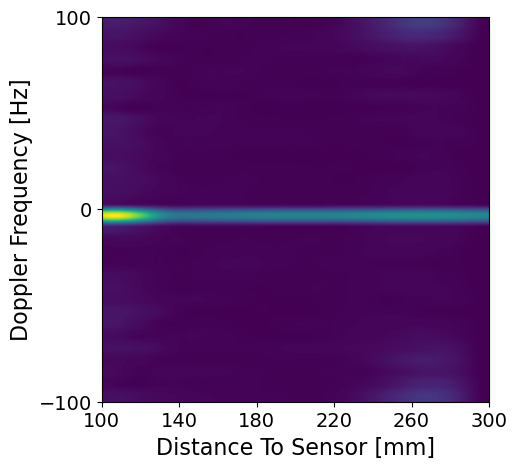

In [20]:
k=8
sr = y[0][k,1,1]
plot_doppler(sr, comp=False)


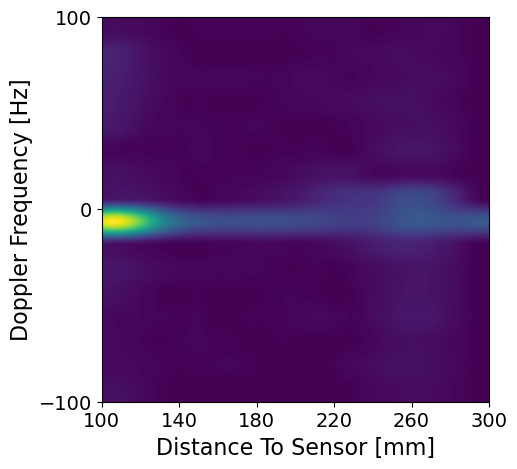

In [11]:
lr2 = lr_imgs2[k,1,1]
plot_doppler(lr2, comp=False)

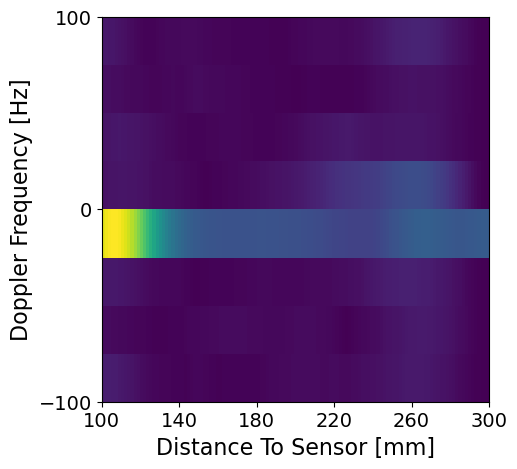

In [12]:
lr4 = lr_imgs4[k,1,1]
plot_doppler(lr4, comp=False)

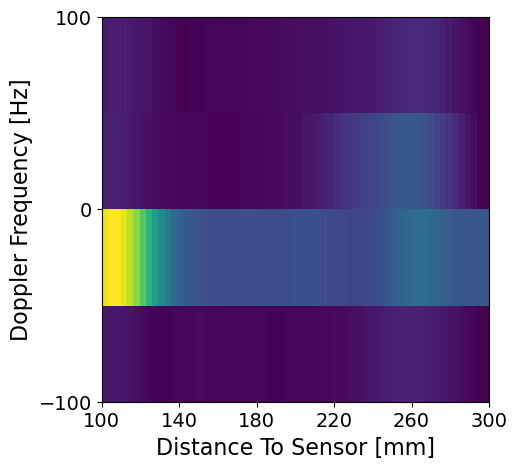

In [13]:
lr8 = lr_imgs8[k,1,1]
plot_doppler(lr8, comp=False)

In [7]:
import os
import cv2
import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
import torch.nn.functional as F

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
from gestures.utils_processing_data import ToTensor,NormalizeOneSample,ComplexToRealOneSample,DopplerMapOneSample,RealToComplexOneSample

In [107]:
import torch
import torch.nn.functional as F
class DownSampleOneSample(torch.nn.Module):
    def __init__(self, D: int, original_dim: bool = False):
        super(DownSampleOneSample, self).__init__()
        self.D = D
        self.original_dim = original_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 5  # (2,5,32,492,2)
        if self.D == 1:
            return x
        res_ds = x[:, :, :: self.D, :: self.D, :]
        if self.original_dim:
            d0, d1, d2, d3, d4 = res_ds.size()
            res_up = torch.empty(
                d0,
                d1,
                d2 * self.D,
                d3 * self.D,
                d4,
                dtype=res_ds.dtype,
                device=res_ds.device,
            )

            for i in range(d0):
                for j in range(d1):
                    for k in range(d4):
                        inter= F.interpolate(
                            res_ds[i, j, :, :, k],
                            size=(32, 492),
                            mode="bicubic",
                        )
                        res_up[i, j, :, :, k] = inter
            return res_up
        return res_ds


to_tensor = ToTensor()
normalize = NormalizeOneSample()
complex_to_real = ComplexToRealOneSample()
real_to_complex = RealToComplexOneSample()

doppler_map = DopplerMapOneSample()
down_sample4 = DownSampleOneSample(4, original_dim=True)
down_sample2 = DownSampleOneSample(2,original_dim=True)
down_sample8 = DownSampleOneSample(8,original_dim=True)

In [108]:
p = "/Users/netanelblumenfeld/Downloads/11G/test/p01_FingerRub_68.npy"
data = np.load(p)
x = to_tensor(data)
x = normalize(x)
xs = complex_to_real(x)
print(xs.shape)

x_lr2 = down_sample2(xs)
print(x_lr2.shape, x_lr2.dtype)
x_lr2 = real_to_complex(x_lr2)
print(x_lr2.shape, x_lr2.dtype)

x_lr2 = doppler_map(x_lr2)


# x_lr4 = down_sample4(xs)
x_lr8 = down_sample8(xs)
x_lr8 = real_to_complex(x_lr8)
x_lr8 = doppler_map(x_lr8)
# x_lr4 = real_to_complex(x_lr4)

# x_lr4 = doppler_map(x_lr4)
x = doppler_map(x)
# print(x.shape,x_lr2.shape,x_lr4.shape,x_lr8.shape)

torch.Size([2, 5, 32, 492, 2])


IndexError: index 2 is out of bounds for dimension 1 with size 2

In [94]:
xs = xs.permute(0,4,1,2,3)
print(xs.shape)
xs1 = xs.unsqueeze(0)
print(xs1.shape)

torch.Size([2, 2, 5, 32, 492])
torch.Size([1, 2, 2, 5, 32, 492])


In [76]:
from scipy.fftpack import fft, fftfreq, fftshift

def plot_doppler1(x):
    plt.rcdefaults()
    # x = torch.tensor(x, dtype=torch.complex64)
    # x = torch.abs(torch.fft.fftshift(torch.fft.fft(x, dim=0), dim=0))
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # Create the axis extent
    
    ax.imshow(x.cpu().numpy(), aspect='auto')
    extent = [100, 300, -110, 110]
    
    ax.imshow(x.cpu().numpy(), aspect='auto', extent=extent)
    # ax.imshow(x.cpu().numpy(), aspect='auto', extent=extent)

    ax.set_ylabel("Doppler Frequency [Hz]", fontsize=16)
    ax.set_xlabel("Distance To Sensor [mm]", fontsize=16)
    ax.set_xticks(np.arange(100, 301, 40))  # Adding custom ticks for x-axis
    ax.set_yticks(np.arange(-100, 101, 100))  # Adding custom ticks for y-axis
    ax.tick_params(axis='both', which='major', labelsize=14)

    
    plt.show()

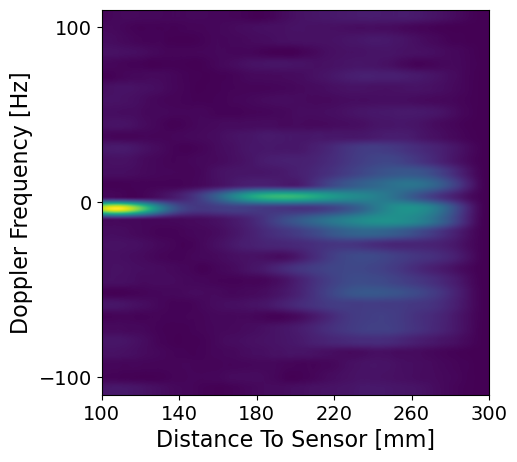

In [81]:
plot_doppler1(x[0,:,:,0])

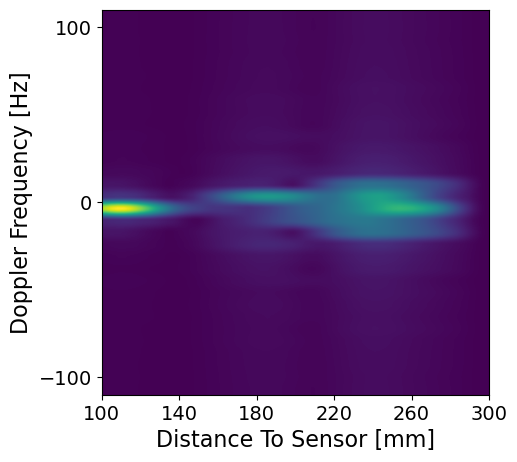

In [82]:
plot_doppler1(x_lr8[0,:,:,0])


In [62]:
data.shape

(5, 32, 492, 2)

In [105]:
y = torch.tensor(img, dtype=img.dtype)

TypeError: tensor(): argument 'dtype' must be torch.dtype, not numpy.dtypes.Complex64DType